In [1]:
import torch as t
from torch import nn
import pandas as pd
import torch.nn.functional as F
import plotly.express as px
import plotly.graph_objects as go
import torchvision
from matplotlib import pyplot as plt
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger
from dataclasses import dataclass
import pytorch_lightning as pl
import wandb

In [2]:
from typing import Tuple


@dataclass
class AEargs():
    in_features: int = 784
    hidden_dim: int = 100
    latent_dim_size: int = 10
    beta: float = 0.1
    img_size: int = 28
    batch_size: int = 512
    epochs: int = 15
    lr: float = 0.001
    betas: Tuple[float] = (0.9, 0.999)
    track: bool = False
    cuda: bool = False

In [3]:
class VariationalAutoencoder(nn.Module):
    encoder: nn.Sequential
    decoder: nn.Sequential

    def __init__(self, args: AEargs):
        super().__init__()
        self.encoder = nn.Sequential(
            Rearrange('b c h w -> b (c h w)'),
            nn.Linear(in_features=args.in_features, out_features=args.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=args.hidden_dim, out_features=args.latent_dim_size*2),
            Rearrange("b (n latent_dim) -> n b latent_dim", n=2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=args.latent_dim_size, out_features=args.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=args.hidden_dim, out_features=args.in_features),
            Rearrange('b (c h w) -> b c h w', h=args.img_size, w=args.img_size),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        mu, logsigma = self.encoder(x)
        sigma = t.exp(logsigma)

        x_compressed = t.randn_like(mu) * sigma + mu

        x_reconstructed = self.decoder(x_compressed)

        return x_reconstructed, mu, logsigma

In [4]:
class VAE_PL(pl.LightningModule):
    def __init__(self, args: AEargs):
        super().__init__()
        self.save_hyperparameters()
        self.args = args
        self.model = VariationalAutoencoder(args)
        self.reconstruction_loss = nn.MSELoss()

    def ELBOLoss(self, x_hat, x, mu, logsigma):
        MSE = self.reconstruction_loss(x_hat, x)
        KLD = (0.5 * (mu.pow(2) + t.exp(logsigma) - 1) - logsigma).mean()
        self.log('KL_divergence', KLD, prog_bar=True)
        return MSE + self.hparams.args.beta * KLD

    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mu, logsigma = self(x)
        loss = self.ELBOLoss(x_hat, x, mu, logsigma)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mu, logsigma = self(x)
        loss = self.ELBOLoss(x_hat, x, mu, logsigma)
        self.log('val_loss', loss, prog_bar=True)

        # Log images every 100 batches
        if batch_idx % 100 == 0:
            images = [wandb.Image(arr) for arr in x_hat[:10]]
            wandb.log({'reconstructed_images': images})

            noise = t.randn(10, self.hparams.args.latent_dim_size)
            x_hat_gen = self.model.decoder(noise)
            gen_images = [wandb.Image(arr) for arr in x_hat_gen]
            wandb.log({'generated_images': gen_images})

    def configure_optimizers(self):
        optimizer = t.optim.Adam(self.parameters(), lr=self.args.lr, betas=self.args.betas, weight_decay=1e-5)
        return optimizer

In [5]:
args = AEargs(epochs=15, batch_size=64, beta=0.1)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=8)
testset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=8)

In [6]:

model = VAE_PL(args)
wandb_logger = WandbLogger(project="Curt-VAE")
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if t.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=args.epochs,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=wandb_logger,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: curt-tigges (arena-ldn). Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(train_dataloaders=trainloader, val_dataloaders=testloader, model=model)


  | Name                | Type                   | Params
---------------------------------------------------------------
0 | model               | VariationalAutoencoder | 160 K 
1 | reconstruction_loss | MSELoss                | 0     
---------------------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.643     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [8]:
output = model(next(iter(trainloader))[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


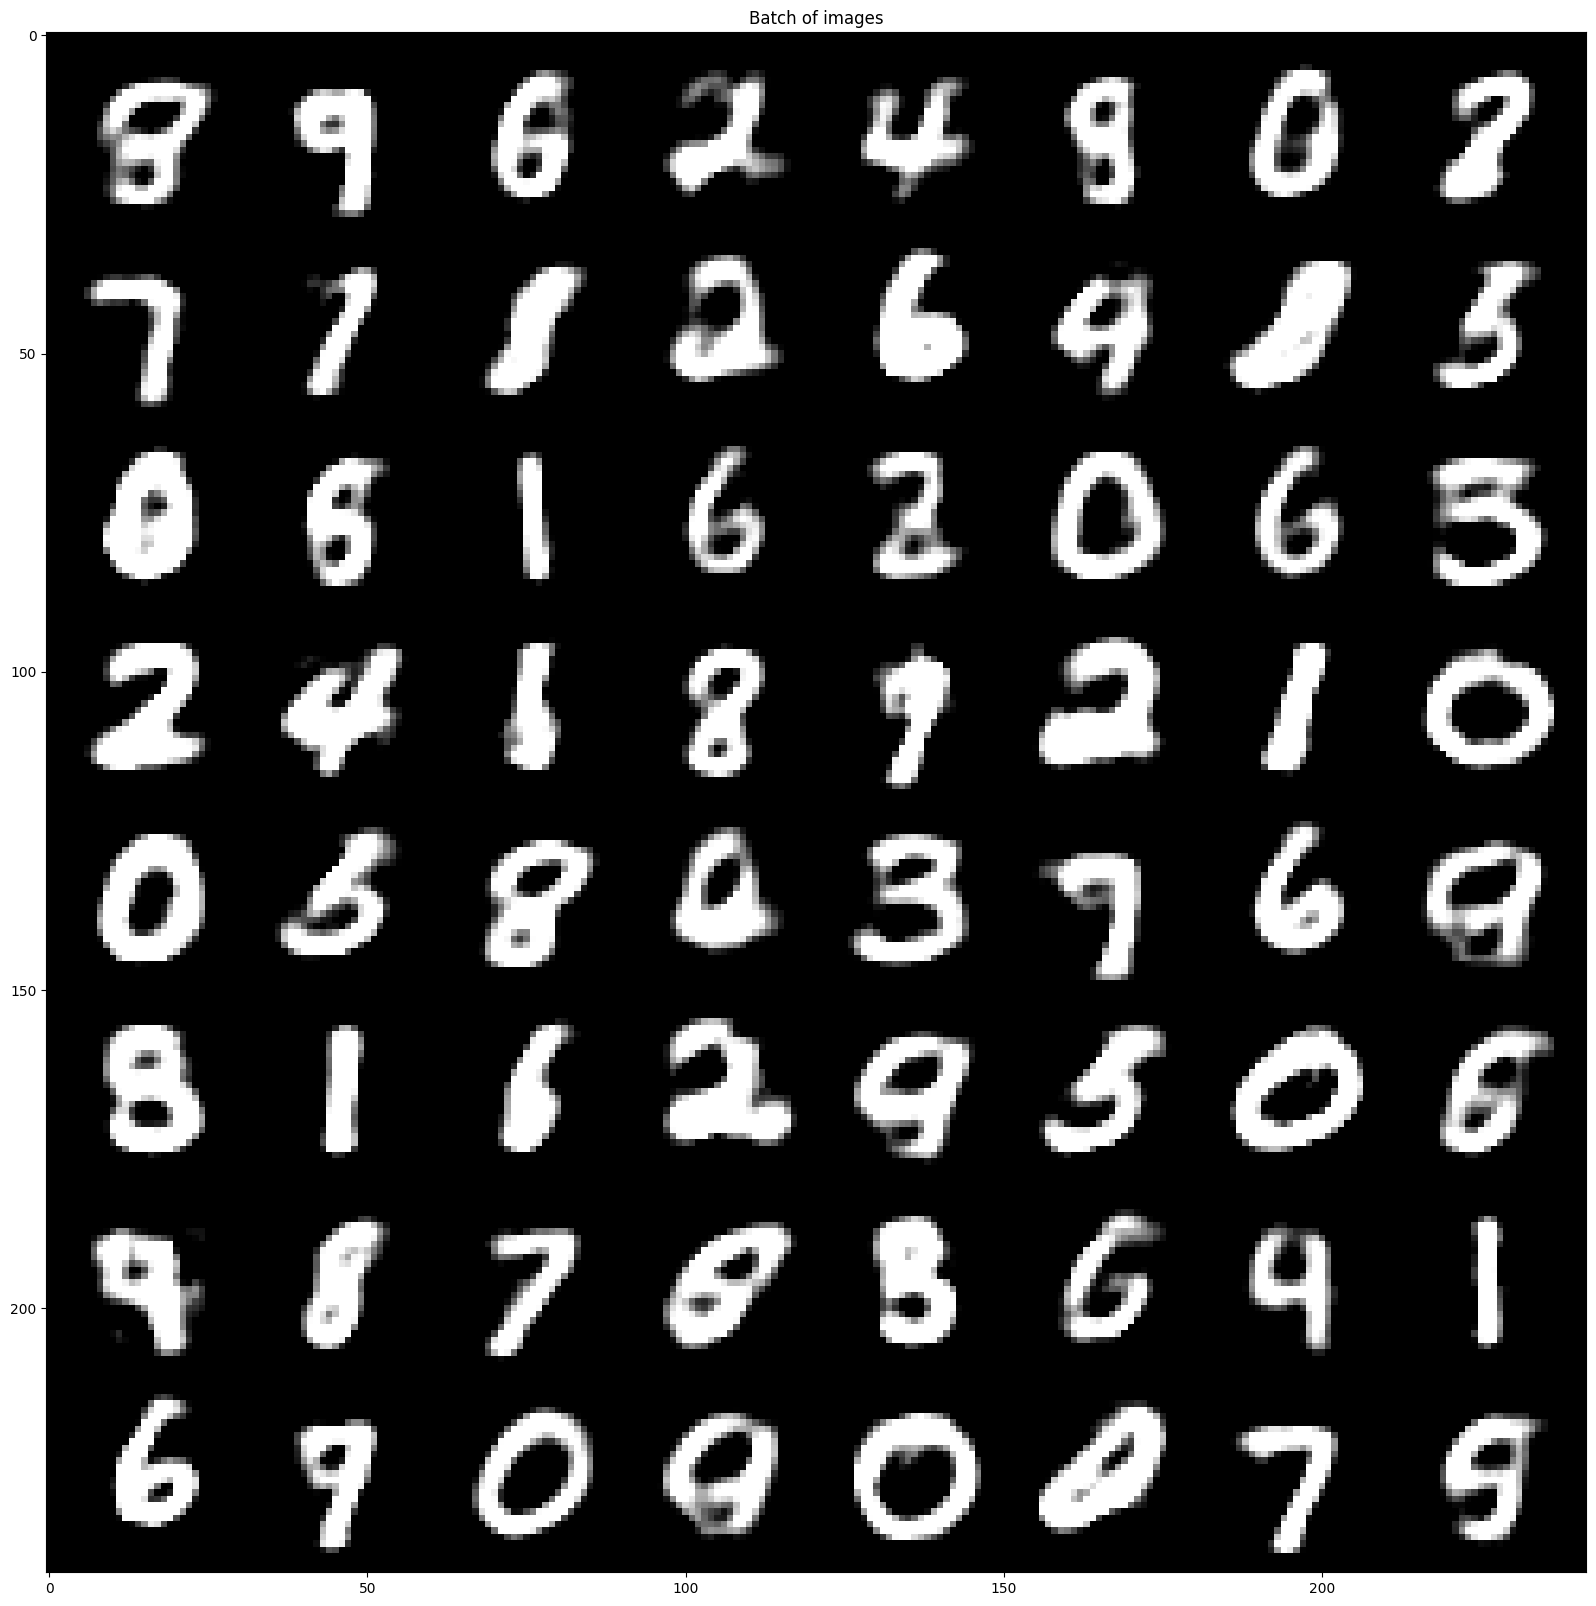

In [9]:
from w5d1_utils import show_images

def display_image_batch(batch: t.Tensor, nrow: int = 8, title: str = "Batch of images"):
    """Function to display a batch of images using PIL"""
    batch = batch.detach().cpu()
    grid = torchvision.utils.make_grid(batch, nrow=nrow)
    plt.figure(figsize=(20, 20))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()
    
display_image_batch(output[0])
